In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx

In [2]:
A =  np.array([ [0, 0, 0, 0, 0, 0, 1, 3, 0, 0], 
                [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 1, 0], 
                [0, 0, 0, 0, 0, 0, 4, 0, 0, 1], 
                [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0, 2], 
                [0, 2, 0, 3, 0, 1, 0, 0, 0, 0],
                [5, 0, 1, 0, 0, 1, 0, 0, 0, 0], 
                [0, 8, 0, 0, 3, 0, 0, 0, 0, 0], 
                [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

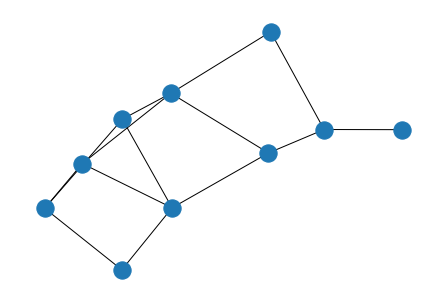

In [3]:
G = nx.from_numpy_array(A)
nx.draw(G)

In [4]:
adj_matrix = pd.DataFrame(A)
adj_matrix

,0,1,2,3,4,5,6,7,8,9
0,0,0,0,0,0,0,1,3,0,0
1,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,4,0,0,1
4,0,0,0,0,0,0,0,0,1,0
5,0,0,0,0,0,0,0,0,0,2
6,0,2,0,3,0,1,0,0,0,0
7,5,0,1,0,0,1,0,0,0,0
8,0,8,0,0,3,0,0,0,0,0
9,1,0,0,0,0,0,0,0,0,0


In [5]:
# Initialise user - user zeros matrix
repos = [0,1,2,3,4,5]
users = [6,7,8,9]

shape = (len(users), len(users))
aux_matrix = pd.DataFrame((np.zeros(shape=shape)), columns=users, index=users)
aux_matrix.shape


(4, 4)

In [6]:
# Get repo - user similarity (upper-right square):
repo_user = adj_matrix.iloc[:len(repos),len(repos):]
repo_user

,6,7,8,9
0,1,3,0,0
1,0,1,0,0
2,0,0,1,0
3,4,0,0,1
4,0,0,1,0
5,0,0,0,2


In [7]:
# Get repo - user similarity (lower-left square):
user_repo = adj_matrix.iloc[len(repos):,:len(repos)]
user_repo

,0,1,2,3,4,5
6,0,2,0,3,0,1
7,5,0,1,0,0,1
8,0,8,0,0,3,0
9,1,0,0,0,0,0


In [8]:
def cosim(vector_a, vector_b):
    
    norma = (np.linalg.norm(vector_a)*np.linalg.norm(vector_b))

    if norma > 0:

        cos_sim = np.dot(vector_a,vector_b)/ norma

    else:

        cos_sim = 0

    return cos_sim

In [9]:
for i in range(4):
    for j in range(4):

        if (i < j):   # upper diagonal -> interaction repo-user

            # Compare row vectors
            aux_vector_a = adj_matrix.iloc[:,i+6] # + 6 to skip repos
            aux_vector_b = adj_matrix.iloc[:,j+6]
            
            score = cosim(aux_vector_a, aux_vector_b)

            aux_matrix.iat[i, j] = score

aux_matrix

,6,7,8,9
6,0.0,0.230089,0.0,0.433861
7,0.0,0.000000,0.0,0.000000
8,0.0,0.000000,0.0,0.000000
9,0.0,0.000000,0.0,0.000000


In [10]:
for i in range(4):
    for j in range(4):

        if (i >= j):   # lower diagonal -> interaction user-repo

            # Compare row vectors
            aux_vector_a = adj_matrix.iloc[i+6,:] # + 6 to skip repos
            aux_vector_b = adj_matrix.iloc[j+6,:]
            
            score = cosim(aux_vector_a, aux_vector_b)

            aux_matrix.iat[i, j] = score

np.fill_diagonal(aux_matrix.to_numpy(), 0)
aux_matrix

,6,7,8,9
6,0.000000,0.230089,0.0,0.433861
7,0.051434,0.000000,0.0,0.000000
8,0.500489,0.000000,0.0,0.000000
9,0.000000,0.962250,0.0,0.000000


In [11]:
# Cosim version Mutator
repo_user = adj_matrix.iloc[:len(repos),len(repos):]
repo_user = repo_user/np.linalg.norm(repo_user,axis=0,keepdims=True)
repo_user[np.isnan(repo_user)] = 0
repo_user = np.dot(repo_user.transpose(),repo_user)

user_repo = adj_matrix.iloc[len(repos):,:len(repos)]
user_repo = user_repo/np.linalg.norm(user_repo,axis=1,keepdims=True)
user_repo[np.isnan(user_repo)] = 0
user_repo = np.dot(user_repo, user_repo.transpose())

user_user = np.triu(repo_user,1) + np.tril(user_repo,-1)

user_user

array([[0.        , 0.2300895 , 0.        , 0.43386092],
       [0.05143445, 0.        , 0.        , 0.        ],
       [0.500489  , 0.        , 0.        , 0.        ],
       [0.        , 0.96225045, 0.        , 0.        ]])

In [12]:
# Cosim version adapted from StackOverflow
repo_user = adj_matrix.iloc[:len(repos),len(repos):]
norm = np.linalg.norm(repo_user,axis=0,keepdims=True)
norm = repo_user/norm
repo_user = np.dot(norm.transpose(),norm)

user_repo = adj_matrix.iloc[len(repos):,:len(repos)]
norm = np.linalg.norm(user_repo,axis=1,keepdims=True)
norm = user_repo/norm
user_repo = np.dot(norm,norm.transpose())

user_user = np.triu(repo_user,1) + np.tril(user_repo,-1)

user_user

array([[0.        , 0.2300895 , 0.        , 0.43386092],
       [0.05143445, 0.        , 0.        , 0.        ],
       [0.500489  , 0.        , 0.        , 0.        ],
       [0.        , 0.96225045, 0.        , 0.        ]])

In [13]:
# Cosim version SKlearn
user_repo = adj_matrix.iloc[len(repos):,:len(repos)]
user_repo = cosine_similarity(user_repo)
repo_user = adj_matrix.iloc[:len(repos),len(repos):]
repo_user = cosine_similarity(repo_user.transpose())

user_user = np.triu(repo_user,1) + np.tril(user_repo,-1)
user_user

array([[0.        , 0.2300895 , 0.        , 0.43386092],
       [0.05143445, 0.        , 0.        , 0.        ],
       [0.500489  , 0.        , 0.        , 0.        ],
       [0.        , 0.96225045, 0.        , 0.        ]])